# Library

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.neural_network import MLPClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
import matplotlib.pyplot as plt
import shap
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report, 
                             roc_curve, auc, precision_score, recall_score, f1_score)
import tensorflow as tf
from tensorflow.keras import layers
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.optimizers import Adam

# 한글 글꼴 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

# 전처리

In [2]:
# 파일 불러오기
file_path = r"C:\Users\james\J DATA LAB\Project-DonationPrediction\data\koweps_check6.csv"
df = pd.read_csv(file_path)
df.head()

,year,h_cobf,h_reg5,h_reg7,h_din,h_cin,h_hc,h01_1,h01_110,h_hc_all,...,p04_3aq5,p04_3aq6,p04_3aq7,p04_3aq8,h09_9,h08_3aq8,h08_195,h12_1,h12_7,h08_aq17
0,2005,0,1,1,608.0,614.0,2,1,1,0,...,0,0,0,0,45,0,0.0,2,1,0.0
1,2011,0,1,1,858.8,896.0,2,1,1,2,...,5,1,1,1,50,0,0.0,2,1,109.0
2,2012,0,1,1,1260.8,1310.0,2,1,1,2,...,4,2,4,2,50,0,0.0,2,1,113.0
3,2013,0,1,1,2172.0,2208.0,1,1,1,1,...,3,2,2,2,80,0,0.0,2,1,116.0
4,2014,0,1,1,864.0,864.0,2,1,1,2,...,2,1,1,1,50,0,0.0,2,1,59.0


In [3]:
df['donation'] = None

# p04_4가 1인 경우
df.loc[df['p04_4'] == 1, 'donation'] = df['p04_5'].apply(lambda x: 1 if x >= 1 else 0)
# p04_4가 2인 경우
df.loc[df['p04_4'] == 2, 'donation'] = 0
# 나머지 경우 삭제 또는 결측치 처리
df = df.dropna(subset=['donation'])

# p04_4에서 1을 선택하고 p04_5에서 1 이하를 적은 사람 삭제
df = df[~((df['p04_4'] == 1) & ((df['p04_5'] <= 1) | (df['p04_5'].isna())))]

# 결측치 제거 (None 값이 있는 행 삭제)
df = df.dropna(subset=['donation'])

# 분석대상(Y) 
y = df['donation'].astype(int)

# 독립 변수(X) 설정 (p04_4와 p04_5를 제외한 나머지)
x = df.drop(columns=['p04_4', 'p04_5', 'donation'])

In [4]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(x, y)

# 특성 중요도 추출
feature_importances = rf_model.feature_importances_

# 중요도가 높은 변수
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': feature_importances
})

# 정렬
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
print(feature_importance_df.head(10))

       Feature  Importance
119      h07_9    0.018445
109      h07_4    0.016751
5        h_cin    0.016471
4        h_din    0.015726
14        h_g6    0.015490
115      h07_5    0.015016
99   h07_3aq11    0.013252
13        h_g4    0.012740
110   h07_6aq7    0.012489
102  h07_3aq13    0.012087


누적 중요도 80%에 해당하는 변수들:
      Feature  Importance  Cumulative_Importance
119     h07_9    0.018445               0.018445
109     h07_4    0.016751               0.035196
5       h_cin    0.016471               0.051667
4       h_din    0.015726               0.067393
14       h_g6    0.015490               0.082882
..        ...         ...                    ...
259    p05_12    0.002921               0.787381
21     h_med1    0.002904               0.790285
174   h10_aq5    0.002884               0.793169
152  h08_aq29    0.002875               0.796045
36     h_soc8    0.002838               0.798883

[134 rows x 3 columns]


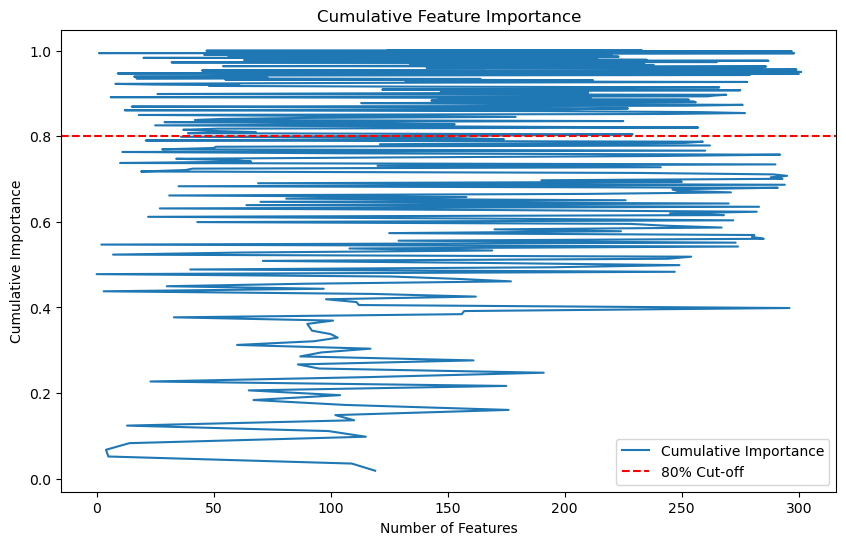

In [5]:
feature_importance_df = pd.DataFrame({
    'Feature': x.columns,
    'Importance': rf_model.feature_importances_
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 누적 중요도 계산
feature_importance_df['Cumulative_Importance'] = feature_importance_df['Importance'].cumsum()

# 중요도 누적 합 80%
cut_off_80 = feature_importance_df[feature_importance_df['Cumulative_Importance'] <= 0.80]
print("누적 중요도 80%에 해당하는 변수들:")
print(cut_off_80)
plt.figure(figsize=(10, 6))
plt.plot(feature_importance_df['Cumulative_Importance'], label='Cumulative Importance')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Cut-off')
plt.title('Cumulative Feature Importance')
plt.xlabel('Number of Features')
plt.ylabel('Cumulative Importance')
plt.legend()
plt.show()

# 샘플링 및 모델링

In [17]:
# 상위 변수만 선택 
important_features = feature_importance_df['Feature'][:134]
x_important = x[important_features]

# 분할 
x_train, x_test, y_train, y_test = train_test_split(x_important, y, test_size=0.2, random_state=42, stratify=y)

# 랜덤 오버샘플링
ros = RandomOverSampler(random_state=42)
x_train_resampled, y_train_resampled = ros.fit_resample(x_train, y_train)

# 스케일링
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train_resampled)
x_test_scaled = scaler.transform(x_test)

# 모델 정의 
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(),
    'CatBoost': CatBoostClassifier(verbose=0),
    'MLP': MLPClassifier(max_iter=1000)
}

# 모델 학습 및 평가
results = []

for name, model in models.items():
    print(f'------{name}------')
    
    model.fit(x_train_scaled, y_train_resampled)
    y_pred = model.predict(x_test_scaled)
    
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
    else:
        y_pred_proba = model.decision_function(x_test_scaled)

    # 평가 지표
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)


    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)


    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    # 결과 저장
    results.append({
        'Algorithm': name,
        'Precision': precision,
        'Recall': recall,
        'Specificity': specificity,
        'F1-score': f1,
        'Accuracy': accuracy,
        'AUC': roc_auc
    })

results_df = pd.DataFrame(results)
results_df


------XGBoost------


C:\Users\james\anaconda3\envs\myenv\lib\site-packages\xgboost\core.py:158: UserWarning: [17:01:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,XGBoost,0.231697,0.703728,0.830656,0.348615,0.822068,0.855892


In [13]:
# CNN
def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(Conv1D(filters=32, kernel_size=2, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))  
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# CNN 모델 학습 및 평가 추가
input_shape = (x_train_scaled.shape[1], 1) 
cnn_model = create_cnn_model(input_shape)

# reshape 
x_train_cnn = x_train_scaled.reshape(x_train_scaled.shape[0], x_train_scaled.shape[1], 1)
x_test_cnn = x_test_scaled.reshape(x_test_scaled.shape[0], x_test_scaled.shape[1], 1)

cnn_model.fit(x_train_cnn, y_train_resampled, epochs=10, batch_size=32, verbose=1)

# CNN 테스트 데이터로 예측
y_pred_cnn = cnn_model.predict(x_test_cnn)
y_pred_cnn = (y_pred_cnn > 0.5).astype(int) 

# CNN 평가 지표 계산
accuracy_cnn = accuracy_score(y_test, y_pred_cnn)
precision_cnn = precision_score(y_test, y_pred_cnn)
recall_cnn = recall_score(y_test, y_pred_cnn)
f1_cnn = f1_score(y_test, y_pred_cnn)

cm_cnn = confusion_matrix(y_test, y_pred_cnn)
tn, fp, fn, tp = cm_cnn.ravel()
specificity_cnn = tn / (tn + fp)

y_pred_proba_cnn = cnn_model.predict(x_test_cnn)
fpr_cnn, tpr_cnn, thresholds_cnn = roc_curve(y_test, y_pred_proba_cnn)
roc_auc_cnn = auc(fpr_cnn, tpr_cnn)

# 저장
results.append({
    'Algorithm': 'CNN',
    'Precision': precision_cnn,
    'Recall': recall_cnn,
    'Specificity': specificity_cnn,
    'F1-score': f1_cnn,
    'Accuracy': accuracy_cnn,
    'AUC': roc_auc_cnn
})

results_df = pd.DataFrame(results)
results_df

Epoch 1/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 27s 2ms/step - accuracy: 0.7435 - loss: 0.5201
Epoch 2/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.7712 - loss: 0.4814
Epoch 3/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.7817 - loss: 0.4648
Epoch 4/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.7881 - loss: 0.4512
Epoch 5/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step - accuracy: 0.7956 - loss: 0.4363
Epoch 6/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 43s 3ms/step - accuracy: 0.8038 - loss: 0.4217
Epoch 7/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8097 - loss: 0.4099
Epoch 8/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8157 - loss: 0.3979
Epoch 9/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8225 - loss: 0.3844
Epoch 10/10
10535/10535 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.8274 - loss: 0.3743
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
1413/1413 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


,Algorithm,Precision,Recall,Specificity,F1-score,Accuracy,AUC
0,Logistic Regression,0.180652,0.755396,0.751370,0.291575,0.751643,0.833108
1,Random Forest,0.548991,0.124591,0.992572,0.203092,0.933845,0.860760
2,XGBoost,0.231697,0.703728,0.830656,0.348615,0.822068,0.855892
3,LightGBM,0.201011,0.780576,0.774840,0.319695,0.775228,0.860107
4,CatBoost,0.259444,0.680510,0.859038,0.375666,0.846959,0.863882
5,MLP,0.218831,0.551014,0.857258,0.313255,0.836538,0.805984
6,CNN,0.195199,0.749836,0.775647,0.309760,0.773901,0.845675


# 전체 기부특성 분석

In [18]:
xgb_model = models['XGBoost']

# 예측 수행
y_test_pred = xgb_model.predict(x_test_scaled)
y_test_proba = xgb_model.predict_proba(x_test_scaled)

# DataFrame
test_results = pd.DataFrame(x_test_scaled, columns=important_features)
test_results['Actual'] = y_test.reset_index(drop=True)
test_results['Predicted'] = y_test_pred
test_results['Donation_Probability'] = y_test_proba[:, 1]

# 기부 확률이 높은 상위 20명
top_donors = test_results.sort_values(by='Donation_Probability', ascending=False).head(20)
top_donors

Feature,h07_9,h07_4,h_cin,h_din,h_g6,h07_5,h07_3aq11,h_g4,h07_6aq7,h07_3aq13,...,h08_107,p04_7,p05_12,h_med1,h10_aq5,h08_aq29,h_soc8,Actual,Predicted,Donation_Probability
2628,0.015422,0.040704,0.367549,0.373702,1.000,0.012501,0.219013,0.644231,0.670874,0.003835,...,0.333333,0.000,0.111111,0.000,0.0000,0.000076,0.083333,0,1,0.995305
25255,0.010852,0.013801,0.374075,0.384653,0.500,0.014501,0.049338,0.586538,0.230516,0.003835,...,0.000000,0.000,0.111111,0.000,0.0000,0.000032,0.000000,0,1,0.993595
8127,0.008904,0.021402,0.359956,0.370188,1.000,0.007701,0.062575,0.548077,0.347603,0.002677,...,0.000000,0.125,0.111111,0.000,0.0000,0.000000,0.083333,1,1,0.993345
1475,0.012591,0.011301,0.358411,0.369541,0.875,0.012501,0.090253,0.625000,0.190267,0.002773,...,0.000000,0.000,0.111111,0.125,0.0000,0.000000,0.083333,0,1,0.991697
41057,0.012250,0.035304,0.359366,0.366495,1.000,0.011601,0.194946,0.615385,0.613794,0.001624,...,0.000000,0.125,0.222222,0.000,0.0000,0.000000,0.000000,1,1,0.990716
44227,0.011132,0.006901,0.352513,0.365104,0.750,0.008001,0.016847,0.625000,0.090011,0.003317,...,0.333333,0.000,0.111111,0.125,0.0000,0.000120,0.083333,1,1,0.988238
34278,0.010363,0.041304,0.364165,0.370860,1.000,0.008501,0.054152,0.644231,0.735456,0.001167,...,0.000000,0.000,0.111111,0.000,0.0000,0.000040,0.083333,1,1,0.987869
16990,0.004124,0.007201,0.340845,0.354239,0.875,0.002100,0.001203,0.548077,0.015551,0.000974,...,0.166667,0.000,0.111111,0.000,0.0000,0.000000,0.083333,1,1,0.986817
739,0.012574,0.031603,0.364895,0.372800,0.750,0.011301,0.128761,0.663462,0.512258,0.000834,...,0.333333,0.000,0.111111,0.000,0.0000,0.000000,0.083333,0,1,0.986600
10776,0.016479,0.043504,0.393760,0.397673,1.000,0.024802,0.038508,0.682692,0.544823,0.001501,...,0.333333,0.125,0.222222,0.125,0.0000,0.000000,0.000000,0,1,0.986147


# SHAP 분석

In [83]:
x_test_scaled_df = pd.DataFrame(x_test_scaled, columns=important_features)

# 변수 매핑 
variable_mapping = {
    'h_eco1': '가구원번호',
    'h_soc_13': '건강보험 가입여부',
    'h_g6': '교육수준',
    'h_eco4': '주된 경제활동 참여상태',
    'h_med8': '건강검진 횟수',
    'h_g4': '태어난 연도',
    'h_med2': '건강상태',
    'h_g2': '가구주와의 관계',
    'h01_1': '가구원수',
    'h_g11': '종교',
    'p03_1': '인터넷 사용 여부',
    'p03_11': '여가생활만족도',
    'h_cin': '경상소득',
    'p05_26' : '나에 대해 대체로 만족',
    'h_inc2_1' : '상용근로자 해당여부',
    'p05_20' : '나는 가치 있는 사람',
    'p05_25' : '긍정적인 태도',
    'h07_3aq13' : '기타소비지출',
    'h07_9' :  '총생활비',
    'h07_4' : '세금',
    'h07_3aq11' : '교양오락비' ,
    'h07_6aq6' : '종교관련비(십일조)',
    'h07_5' : '사회보장부담금',
    'h05_3aq2' : '민간의료보험의 12월 기준 보험료',
    'h07_5aq1' : '식료품비 - 주류 및 담배',
    'h08_6aq3' : '세금환급금',
    'h10_aq7' : '금융자산-적금',
    'p03_9' : '직업 만족도',
    'h08_aq9' : '이자, 배당금, 연간소득',
    'h10_27' : '소유한 자동차 가격',
    'h08_aq34' : '민간 개인 또는 단체로 부터 받은 보조금',
    'h17_1' : '1년간 근심이나 갈등을 초래한 문제',
    'h07_3aq9' : '교육비-공교육비',
    'h07_6aq7' : '세금-소득세',
    'h07_6aq14' : '사회보장부담-고용보험료',
    'h07_6aq13' : '사회보장부담-건강보험료',
    'h06_4' : '(주택)방수',
    'h07_3aq15' : '부모에게 보낸 월평금 송금보조비',
    'h07_6aq8' : '재산세',
    'h07_6aq1' : '광열수도비- 난방비'
}

# 매핑된 변수로 변경 
x_test_scaled_df.rename(columns=variable_mapping, inplace=True)

# 피처 리스트
feature_names = x_test_scaled_df.columns.tolist()

In [84]:
# SHAP Explainer 생성
explainer = shap.TreeExplainer(model)

# SHAP 값 계산
shap_values = explainer.shap_values(x_test_scaled_df)

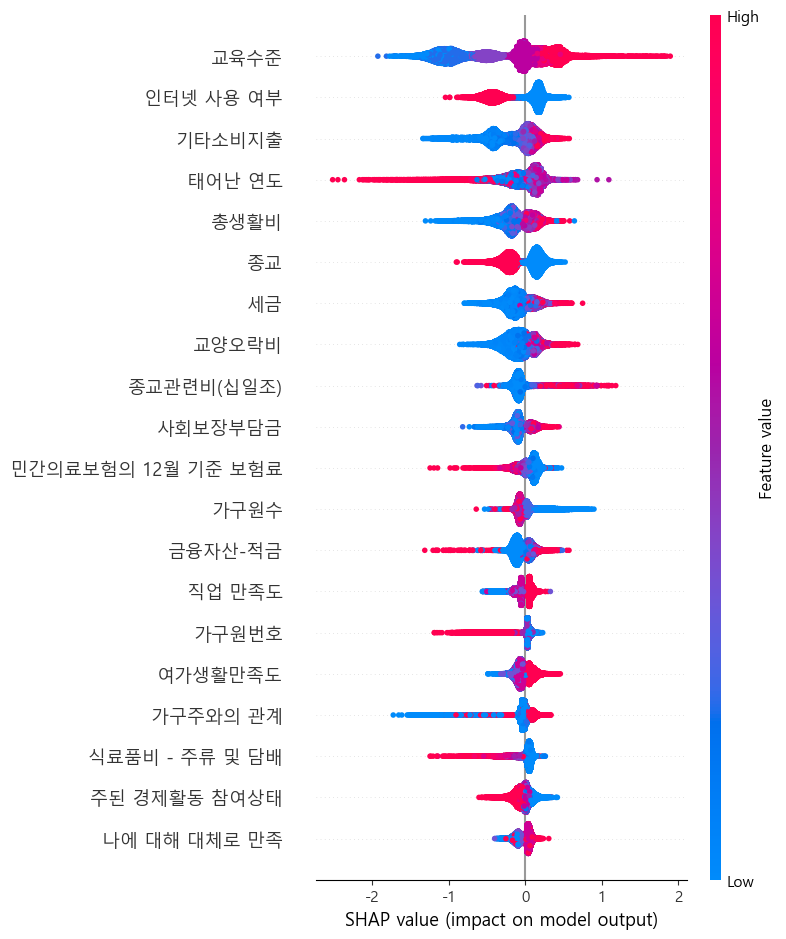

In [85]:
# SHAP Summary Plot
shap.summary_plot(shap_values, x_test_scaled_df, feature_names=feature_names)

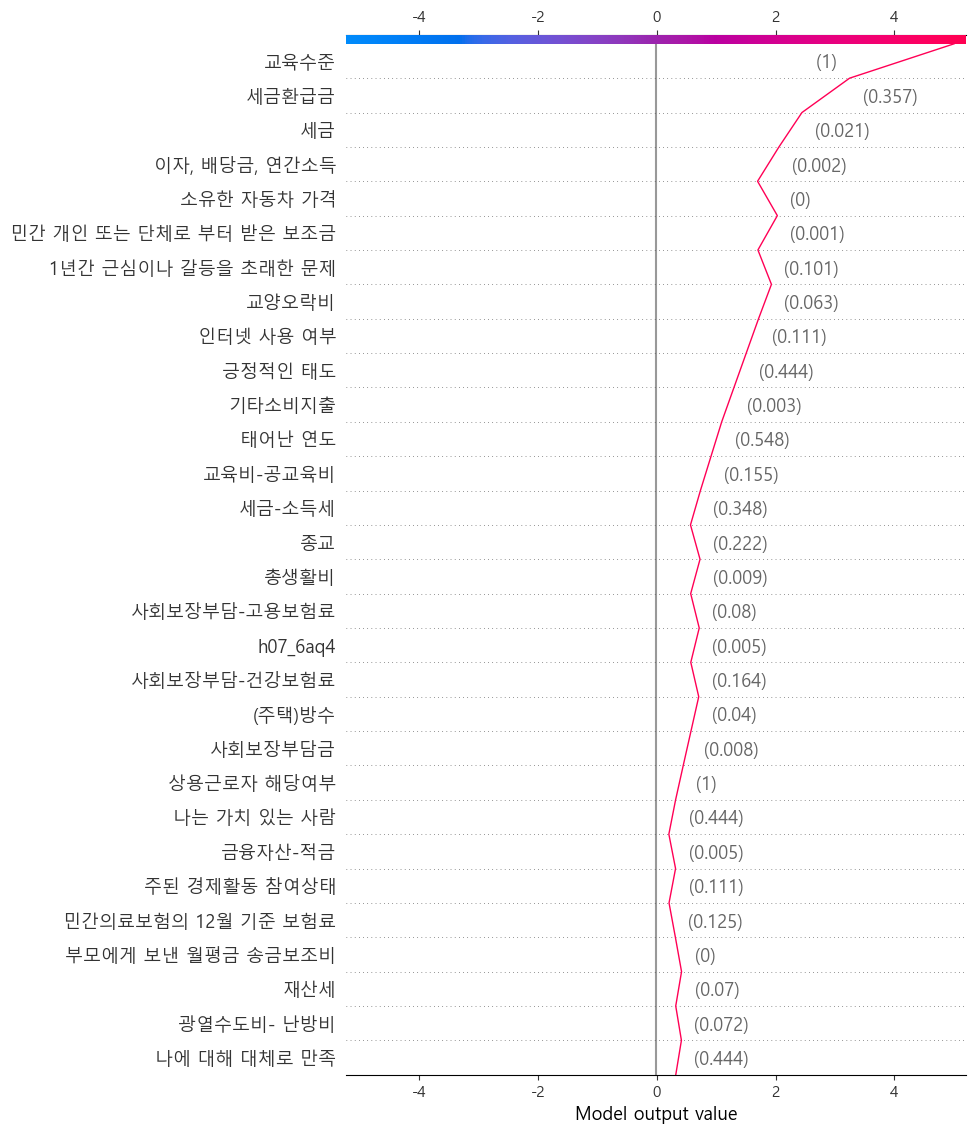

In [86]:
# Decision Plot 
instance_index = 8127  # 인덱스

shap.decision_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values[instance_index],
    features=x_test_scaled_df.iloc[instance_index],
    feature_names=feature_names,
    feature_display_range=slice(None, -31, -1)  
)


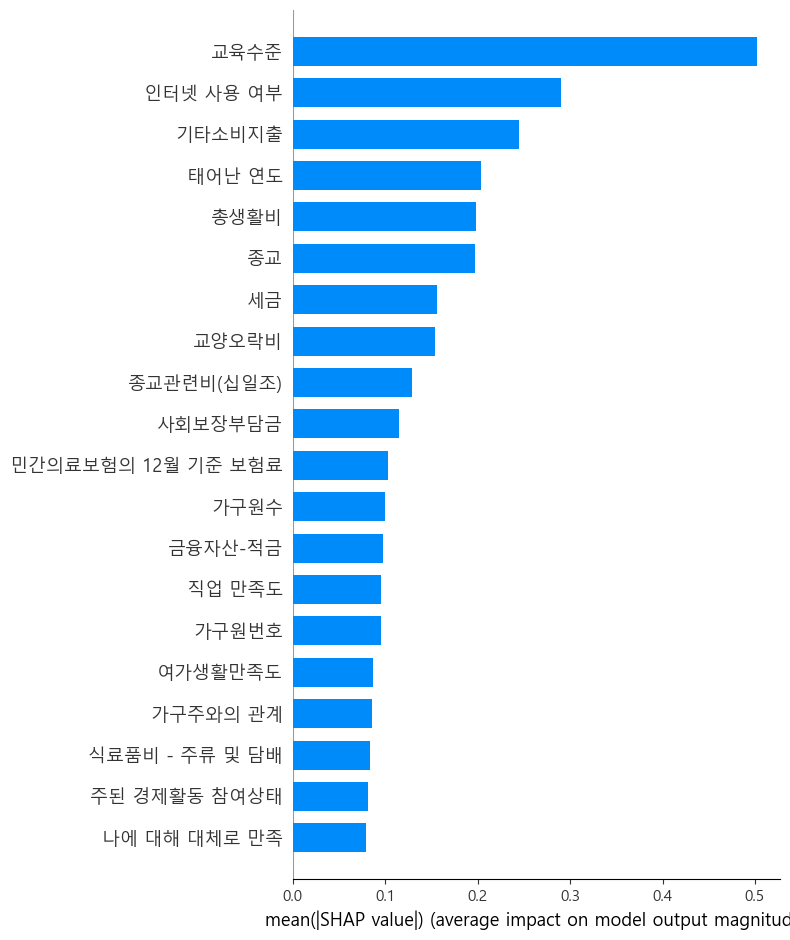

In [89]:
# 중요도 막대 그래프 
shap.summary_plot(shap_values, x_test_scaled_df, feature_names=feature_names, plot_type="bar")